In [96]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
import librosa
from google.colab import drive
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd

from tqdm import tqdm

import IPython.display

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [99]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Small EDA of one signal

In [100]:
df_files = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/selected_records.csv')

This is dataframe with all links to files

In [101]:
df_files.shape

(1762, 12)

In [102]:
df_files.sample(5)

,Unnamed: 0,id,path,point,time,model,label,duration,rec_id,n_seg,length,predicted_label
1629,3531,ab653d86132500fb,./audio_files/20211201-135908-ab653d86132500fb...,spine03,20211201-135908,Xiaomi Redmi Note 9 Pro | 11,normal,13.824,ab653d86132500fb_spine03,1,13.545397,True
655,2286,201e5e0eb13582ab,./audio_files/20210601-123329-201e5e0eb13582ab...,chest01,20210601-123329,Xiaomi Redmi Note 9 Pro | 10,problems,7.168,201e5e0eb13582ab_chest01,1,6.912608,True
53,1249,a2ca3ce9c78b5993,./audio_files/20190817-114816-a2ca3ce9c78b5993...,chest04,20190817-114816,HUAWEI ANE-LX1 | 8.0.0,problems,13.696,a2ca3ce9c78b5993_chest04,1,13.463810,True
630,2248,f0305807be4e4d26,./audio_files/20210520-090943-f0305807be4e4d26...,chest03,20210520-090943,Xiaomi Redmi Note 9 Pro | 10,problems,5.632,f0305807be4e4d26_chest03,7,4.342132,True
827,2502,8c71b1cdc6598e55,./audio_files/20210705-105308-8c71b1cdc6598e55...,spine01,20210705-105308,Xiaomi Redmi Note 9 Pro | 10,problems,6.656,8c71b1cdc6598e55_spine01,2,6.330930,True


In [103]:
df_files['label'].value_counts()

problems    1146
normal       616
Name: label, dtype: int64

In [104]:
display(df_files.isna().sum(axis=0).sort_values(ascending = False).head(4))
df_files.isna().sum(axis=1).value_counts()

Unnamed: 0    0
id            0
path          0
point         0
dtype: int64

0    1762
dtype: int64

In [105]:
df_files['label'].value_counts()

problems    1146
normal       616
Name: label, dtype: int64

Encoding of target to 0/1 where 1 is sick

In [106]:
df_files['target'] = 0
df_files.loc[df_files[df_files['label'] == 'problems'].index,'target'] = 1

In [107]:
df_files['target'].value_counts()

1    1146
0     616
Name: target, dtype: int64

In [108]:
df_files.sample(5)

,Unnamed: 0,id,path,point,time,model,label,duration,rec_id,n_seg,length,predicted_label,target
1180,2949,e7691680fdb63767,./audio_files/20210910-111817-e7691680fdb63767...,chest04,20210910-111817,Xiaomi Redmi Note 9 Pro | 10,problems,6.656,e7691680fdb63767_chest04,1,6.400590,True,1
128,1326,466a8f937ef9285f,./audio_files/20190909-162139-466a8f937ef9285f...,chest01,20190909-162139,HUAWEI ANE-LX1 | 8.0.0,normal,11.648,466a8f937ef9285f_chest01,1,11.415828,True,0
900,2590,bec20fb2641fc057,./audio_files/20210708-113425-bec20fb2641fc057...,spine02,20210708-113425,Xiaomi Redmi Note 9 Pro | 10,problems,5.888,bec20fb2641fc057_spine02,1,5.632608,True,1
746,2394,fa47d547bd94df57,./audio_files/20210607-150328-fa47d547bd94df57...,spine04,20210607-150328,Xiaomi Mi A2 | 10,problems,3.456,fa47d547bd94df57_spine04,1,3.293469,True,1
666,2299,72174c2362ec2988,./audio_files/20210601-123507-72174c2362ec2988...,chest04,20210601-123507,Xiaomi Redmi Note 9 Pro | 10,problems,9.728,72174c2362ec2988_chest04,1,9.449388,True,1


In [109]:
df_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1762 non-null   int64  
 1   id               1762 non-null   object 
 2   path             1762 non-null   object 
 3   point            1762 non-null   object 
 4   time             1762 non-null   object 
 5   model            1762 non-null   object 
 6   label            1762 non-null   object 
 7   duration         1762 non-null   float64
 8   rec_id           1762 non-null   object 
 9   n_seg            1762 non-null   int64  
 10  length           1762 non-null   float64
 11  predicted_label  1762 non-null   bool   
 12  target           1762 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 167.0+ KB


time column to Datetime in pandas

In [110]:
df_files['Date'] = df_files['time'].str.slice(start=0, stop=8)
df_files['Time'] = df_files['time'].str.slice(start=9, stop=11) + ':' + df_files['time'].str.slice(start=11, stop=13)



In [111]:
df_files.head(5)

,Unnamed: 0,id,path,point,time,model,label,duration,rec_id,n_seg,length,predicted_label,target,Date,Time
0,1188,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest03,20190814-220020,samsung SM-A605FN | 8.0.0,normal,2.944,e70516a491f41f9d_chest03,1,2.433197,True,0,20190814,22:00
1,1189,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest04,20190814-220020,samsung SM-A605FN | 8.0.0,normal,3.584,e70516a491f41f9d_chest04,1,2.957098,True,0,20190814,22:00
2,1196,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest01,20190815-084903,samsung SM-A605FN | 8.0.0,problems,10.240,1da9189c64909401_chest01,1,9.752381,True,1,20190815,08:49
3,1197,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest02,20190815-084903,samsung SM-A605FN | 8.0.0,problems,12.800,1da9189c64909401_chest02,1,12.289161,True,1,20190815,08:49
4,1198,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest03,20190815-084903,samsung SM-A605FN | 8.0.0,problems,12.672,1da9189c64909401_chest03,1,12.161179,True,1,20190815,08:49


In [112]:
# Convert the date and time components into a datetime object
df_files['Datetime'] = pd.to_datetime(df_files['Date'].astype(str) + ' ' + df_files['Time'], format='%Y%m%d %H:%M')

# Drop the intermediate date and time columns and display the resulting DataFrame
df_files.drop(['time', 'Date', 'Time'], axis=1, inplace=True)


In [113]:
df_files.head()

,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime
0,1188,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest03,samsung SM-A605FN | 8.0.0,normal,2.944,e70516a491f41f9d_chest03,1,2.433197,True,0,2019-08-14 22:00:00
1,1189,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest04,samsung SM-A605FN | 8.0.0,normal,3.584,e70516a491f41f9d_chest04,1,2.957098,True,0,2019-08-14 22:00:00
2,1196,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest01,samsung SM-A605FN | 8.0.0,problems,10.240,1da9189c64909401_chest01,1,9.752381,True,1,2019-08-15 08:49:00
3,1197,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest02,samsung SM-A605FN | 8.0.0,problems,12.800,1da9189c64909401_chest02,1,12.289161,True,1,2019-08-15 08:49:00
4,1198,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest03,samsung SM-A605FN | 8.0.0,problems,12.672,1da9189c64909401_chest03,1,12.161179,True,1,2019-08-15 08:49:00


Not all the files were good, author said need to filter by date

In [114]:
df_files[df_files['Datetime'] < '2019-08-14']

,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime


In [115]:
df_files.reset_index(inplace=True)

This is the longest track, the arrays must be of its length

In [116]:
df_files[df_files['duration'] == df_files['duration'].max()]

,index,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime
1537,1537,3409,fbadfe1bfd7877e1,./audio_files/20211117-153417-fbadfe1bfd7877e1...,chest04,Xiaomi Redmi Note 9 Pro | 10,problems,31.616,fbadfe1bfd7877e1_chest04,1,31.36059,True,1,2021-11-17 15:34:00


In [117]:
df_files.describe()

,index,Unnamed: 0,duration,n_seg,length,target
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000
mean,880.500000,2517.551646,8.197448,1.437571,7.831884,0.650397
std,508.789904,721.833243,4.168706,2.215483,4.110011,0.476980
min,0.000000,1188.000000,1.408000,1.000000,1.373469,0.000000
25%,440.250000,2017.250000,4.992000,1.000000,4.736599,0.000000
50%,880.500000,2567.500000,6.784000,1.000000,6.400590,1.000000
75%,1320.750000,3125.500000,10.752000,1.000000,10.263810,1.000000
max,1761.000000,3685.000000,31.616000,29.000000,31.360590,1.000000


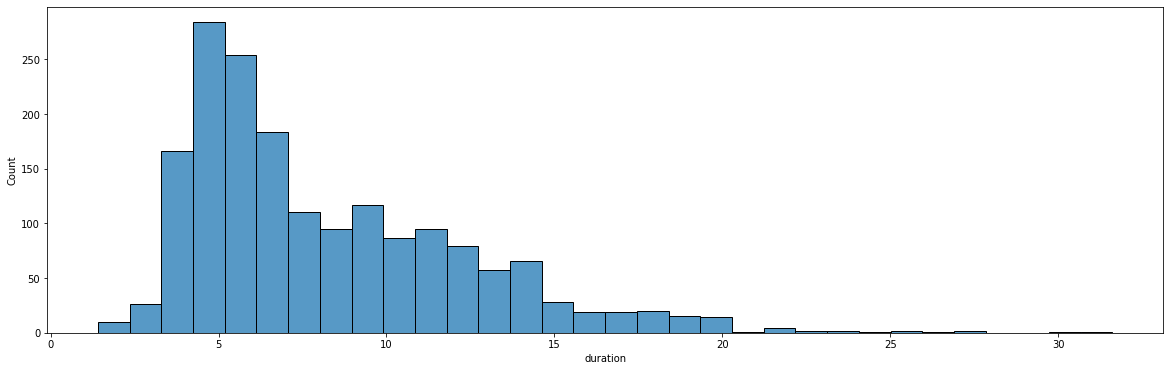

In [118]:
import seaborn as sns
fig = plt.figure(figsize=(20,6))
sns.histplot(df_files['duration']);

In [119]:
# df_files.drop(df_files[df_files['duration'] < 1].index, axis=0, inplace=True)
# df_files.reset_index(inplace=True)
# df_files.shape

In [120]:
df_files.head()

,index,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime
0,0,1188,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest03,samsung SM-A605FN | 8.0.0,normal,2.944,e70516a491f41f9d_chest03,1,2.433197,True,0,2019-08-14 22:00:00
1,1,1189,e70516a491f41f9d,./audio_files/20190814-220020-e70516a491f41f9d...,chest04,samsung SM-A605FN | 8.0.0,normal,3.584,e70516a491f41f9d_chest04,1,2.957098,True,0,2019-08-14 22:00:00
2,2,1196,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest01,samsung SM-A605FN | 8.0.0,problems,10.240,1da9189c64909401_chest01,1,9.752381,True,1,2019-08-15 08:49:00
3,3,1197,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest02,samsung SM-A605FN | 8.0.0,problems,12.800,1da9189c64909401_chest02,1,12.289161,True,1,2019-08-15 08:49:00
4,4,1198,1da9189c64909401,./audio_files/20190815-084903-1da9189c64909401...,chest03,samsung SM-A605FN | 8.0.0,problems,12.672,1da9189c64909401_chest03,1,12.161179,True,1,2019-08-15 08:49:00


In [121]:
df_positive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/positives.csv', header=None)

In [122]:
df_negative = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/negatives.csv', header=None)

In [123]:
df_positive = './audio_files/' +  df_positive[0].str.lstrip('http://lungs.makseq.com/data/service/')


In [124]:
df_negative = './audio_files/' +  df_negative[0].str.lstrip('http://lungs.makseq.com/data/service/')

In [125]:
df_positive

0      ./audio_files/20211101-125147-b5a05864b4f448a1...
1      ./audio_files/20211101-125147-b5a05864b4f448a1...
2      ./audio_files/20211101-125147-b5a05864b4f448a1...
3      ./audio_files/20211029-100738-0657eaa451ac2742...
4      ./audio_files/20211029-100738-0657eaa451ac2742...
                             ...                        
145    ./audio_files/20210915-140850-d594cbe6e2461128...
146    ./audio_files/20210916-115907-e56a0cb1b234b74f...
147    ./audio_files/20210916-115907-e56a0cb1b234b74f...
148    ./audio_files/20210916-115907-e56a0cb1b234b74f...
149    ./audio_files/20210916-115907-e56a0cb1b234b74f...
Name: 0, Length: 150, dtype: object

In [126]:
df_files[df_files['path'].isin(df_positive)]['target'].sum()

146

In [127]:
#two labels incorrect

In [128]:
df_files.loc[df_files['path'].isin(df_positive), 'target'] = 1

In [129]:
df_files[df_files['path'].isin(df_negative)]['target'].sum()

34

In [130]:
#34 labels are incorrect

In [131]:
df_files.loc[df_files['path'].isin(df_negative), 'target'] = 0

In [132]:
df_files['isgood'] = 0

In [133]:
df_files.loc[df_files['path'].isin(df_negative), 'isgood'] = 1

In [134]:
df_files.loc[df_files['path'].isin(df_positive), 'isgood'] = 2

In [135]:
df_files.sample(5)

,index,Unnamed: 0,id,path,point,model,label,duration,rec_id,n_seg,length,predicted_label,target,Datetime,isgood
1364,1364,3179,88fe162efde77c67,./audio_files/20211022-000528-88fe162efde77c67...,chest04,Xiaomi M2003J15SC | 10,normal,6.656,88fe162efde77c67_chest04,1,6.400590,True,0,2021-10-22 00:05:00,0
1605,1605,3501,64f9c13f97eee760,./audio_files/20211130-121333-64f9c13f97eee760...,spine03,Xiaomi Redmi Note 9 Pro | 11,normal,6.016,64f9c13f97eee760_spine03,1,5.783810,True,0,2021-11-30 12:13:00,0
340,340,1779,19590208025dad9e,./audio_files/20210126-103558-19590208025dad9e...,chest04,Xiaomi Mi A2 | 10,problems,5.376,19590208025dad9e_chest04,1,5.190249,True,1,2021-01-26 10:35:00,0
584,584,2197,6d44ac7639a32a3f,./audio_files/20210506-123320-6d44ac7639a32a3f...,chest02,HUAWEI ANE-LX1 | 8.0.0,normal,11.008,6d44ac7639a32a3f_chest02,1,10.775828,True,0,2021-05-06 12:33:00,0
1230,1230,3011,0c1cb7bc2b7df7fb,./audio_files/20210914-100648-0c1cb7bc2b7df7fb...,spine03,Xiaomi Redmi Note 9 Pro | 10,problems,4.352,0c1cb7bc2b7df7fb_spine03,1,4.003719,True,1,2021-09-14 10:06:00,0


In [136]:
df_files.isgood.value_counts()

0    1462
1     152
2     148
Name: isgood, dtype: int64

In [137]:
df_files.shape

(1762, 15)

In [138]:
# for row in np.random.randint(0, len(df_files['path']), 10):
#   path_temp = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + df_files.loc[row, 'path'].lstrip('.')
#   signal_temp,sample_rate_temp = librosa.load(path_temp)
#   plt.figure(figsize = (20,8))
#   librosa.display.waveshow(signal_temp,sr=sample_rate)
#   print(path_temp)
#   plt.show();

In [139]:
# df_files.drop(df_files[df_files['duration'] < 1].index, axis=0, inplace=True)
# df_files.reset_index(inplace=True)
# df_files.shape

In [140]:
# threshold = 2
# zeros = 0
# shorts = 0
# error_duration = []
# errors = 0
# short_indexes = []
# durations = []
# for i, row in tqdm(df_files.iterrows(), total=len(df_files['path'])):
#     path = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + df_files.loc[i]['path'].lstrip('.')
#     signal,sample_rate = librosa.load(path)
#     if signal.sum() == 0:
#       # print('zero  ', path)
#       zeros += 1
#     else: 
#       try:
#         if librosa.get_duration(signal, sample_rate) < threshold:
#         # print('less than second', path, librosa.get_duration(signal, sample_rate))
#           shorts += 1
#           short_indexes.append(i)
#         durations.append(librosa.get_duration(signal, sample_rate))
#       except:
#         errors += 1
#         error_duration.append(path)


In [141]:
# shorts, zeros, errors, len(df_files['path'])

In [142]:
# error_duration

In [143]:
threshold = 2
delete_index = []
errors = 0

for i, row in tqdm(df_files.iterrows(), total=len(df_files['path'])):
    path = '/content/drive/MyDrive/Colab Notebooks/Project/pneumonia_files' + df_files.loc[i]['path'].lstrip('.')
    signal,sample_rate = librosa.load(path)
    if signal.sum() == 0:
      # print('zero  ', path)
      delete_index.append(i)
    else: 
      try:
        if librosa.get_duration(signal, sample_rate) < threshold:
          delete_index.append(i)
      except:
        errors += 1
        delete_index.append(i)

100%|██████████| 1762/1762 [05:42<00:00,  5.15it/s]


In [144]:
len(delete_index)

6

In [145]:
df_files.shape

(1762, 15)

In [146]:
df_files = df_files.drop(delete_index)

In [147]:
df_files.shape

(1756, 15)

In [148]:
features = ['id', 'model', 'Datetime', 'point', 'path', 'isgood']

In [149]:
df_features = df_files[features]

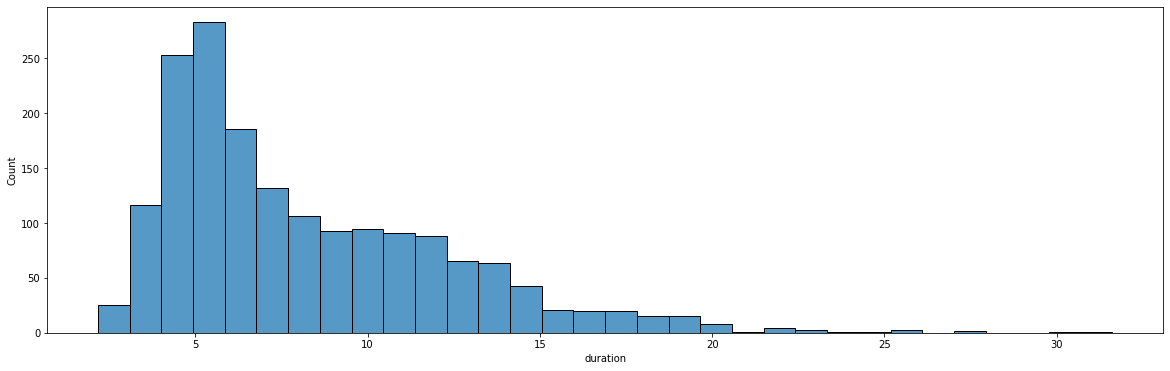

In [150]:
import seaborn as sns
fig = plt.figure(figsize=(20,6))
sns.histplot(df_files['duration']);

In [151]:
df_files.query('isgood == 1 and target == 1').shape

(0, 15)

In [152]:
df_files.query('isgood == 1 and target == 0').shape

(152, 15)

In [153]:
df_files.shape

(1756, 15)

Split into train and test

In [155]:
path_train, path_test, y_train, y_test = train_test_split(df_features, df_files['target'], 
                                                    test_size=0.2 ,random_state=99, stratify=df_files['isgood'])

In [156]:
path_train.shape, path_test.shape, y_train.shape, y_test.shape

((1404, 6), (352, 6), (1404,), (352,))

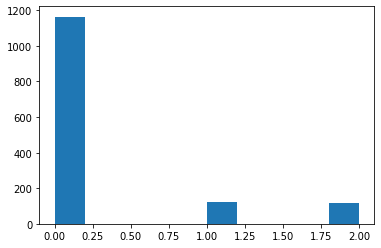

In [158]:
plt.hist(path_train['isgood']);

In [159]:
path_train.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/path_train.csv")
y_train.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_train.csv")
path_test.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/path_test.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/y_test.csv", index=False)

In [ ]:
path_train.head()

In [ ]:
y_train.head()

Gather all tracks into a dataframe, using the train set of paths to files

In [ ]:
# df_features = pd.DataFrame()
# for i in tqdm(df_files.index):
#     path = '/Users/stanislavnevyazhsky/My Drive/Colab Notebooks/Project/pneumonia_files' + df_files.loc[i]['path'].lstrip('.')
#     track,sample_rate = librosa.load(path)
#     # signal = np.pad(signal, (0, max_length-len(signal), 'constant')
#     df_features = df_features.append(pd.Series(track), ignore_index=True)
#     print(i, path)
  

In [ ]:
# df_target = df_files['target']

In [ ]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape


In [ ]:
# X_train.fillna(value=0.0, inplace=True)
# X_test.fillna(value=0.0, inplace=True)

In [ ]:
# zeros = pd.DataFrame(0, index=X_train.index, columns=[X_train.columns[-1] + i+1 for i in range(X_test.columns.shape[0])])

